In [5]:
from utils_csa import save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from pytz import timezone
from datetime import datetime, timedelta, date

from matplotlib import pyplot as plt

# load rf classifier already fitted
clf = load_obj('clf_xgbc_2018_11_19')

# load test data
# X_test = pd.DataFrame(load_obj('clf_rf_2018_11_19_X_test'))
# y_test = pd.DataFrame(load_obj('clf_rf_2018_11_19_y_test'))
# close_price = pd.DataFrame(load_obj('clf_rf_2018_11_19_X_test_close_price'))
# df = pd.concat([X_test, y_test, close_price], axis=1, sort=False)

X_test = load_obj('clf_xgbc_2018_11_19_X_test')
y_test = load_obj('clf_xgbc_2018_11_19_y_test')
close_price = load_obj('clf_xgbc_2018_11_19_X_test_close_price')
target = load_obj('clf_xgbc_2018_11_19_target')

In [81]:
# inspiration backtrader https://www.backtrader.com/docu/quickstart/quickstart.html
# vizualisation : https://www.quantnews.com/algo-trading-with-rest-api-and-python-part-4/
# Goal : Create a class that is generic and can be used easialy

In [56]:
# Checker le buzz là : https://www.quantnews.com/algo-trading-with-rest-api-and-python-part-4/

class Backtesting_strategy:
    param_init_amount = 1000 # $
    param_fees = 0.001 # 0.1%
    bet_size = 1.00
    min_bet_size = 100 # $
    nb_periods_to_hold_position = 24 #1d => sell must be done if pct_change model touched / check close price
    nb_periods_price_to_buy = 1 # approx, actions will have delay
    
    market_price_begin = close_price[0]
    market_price_end = close_price[len(close_price) - 1]
    
    fees_payed = 0
    
    signals_x_buy = []
    signals_y_buy = []
    
    x_sell = []
    y_sell = []
    
    amount_x = []
    amount_y = []

    def __init__(self, clf, X_test, close_price, target, threshold):
        self.clf = clf
        self.X_test = X_test
        self.close_price = close_price      
        self.target = target
        
        self.current_amount = self.param_init_amount
        self.positions = {} # key=index when position taken, value=crypto amount
        self.__calcul_signals(threshold)
        
        self.amount_x.append(0)
        self.amount_y.append(self.param_init_amount)
    
    def __calcul_signals(self, threshold):        
        predicted_proba = self.clf.predict_proba(self.X_test)
        probs = predicted_proba[:, 1] # 0 or 1
        self.signals = (probs >= threshold)

    def __can_buy(self):
        return self.current_amount >= self.min_bet_size

    def __do_buy(self, key):
        amount_to_use = self.current_amount * self.bet_size
        self.current_amount = self.current_amount - amount_to_use
        crypto_amount_to_buy = amount_to_use / close_price[key + self.nb_periods_price_to_buy] # take +1h, approx, bof
        crypto_amount_after_fees = crypto_amount_to_buy - (crypto_amount_to_buy * self.param_fees)
        self.positions[key] = crypto_amount_after_fees
        fees = (crypto_amount_to_buy - crypto_amount_after_fees) * close_price[key + self.nb_periods_price_to_buy]
        self.fees_payed = self.fees_payed + fees
        print('BUY TRADE (' + str(key) + '): ' + str(crypto_amount_after_fees) + ' tokens for ' + str(amount_to_use) + '$ (close_price = ' 
              + str(close_price[key + self.nb_periods_price_to_buy]) + '$ / fees = '
              + str(round(fees, 2)) + '$)')
        
        self.signals_x_buy.append(key)
        self.signals_y_buy.append(close_price[key + self.nb_periods_price_to_buy])

    def __should_sell(self, key):
        # position holded for n periods
        return (key - self.nb_periods_to_hold_position) in self.positions

    def __do_sell(self, key, signal):
        position_crypto_amount = self.positions[key - self.nb_periods_to_hold_position]
        del self.positions[key - self.nb_periods_to_hold_position]
        
        # No sell reset current position
        if signal:
            self.positions[key] = position_crypto_amount
        else:
            self.__sell(key, position_crypto_amount)        
            
    def __do_sell_all(self, key):
        total_crypto = 0
        for key, value in self.positions.items():
            total_crypto = total_crypto + value
        
        if total_crypto > 0:
            self.__sell(key, total_crypto)
            self.positions.clear()

    def __sell(self, key, position_crypto_amount):
        sell_amount = position_crypto_amount * self.close_price[key + self.nb_periods_price_to_buy]
        fees = sell_amount * self.param_fees
        sell_amount_after_fees = sell_amount - fees
        self.current_amount = self.current_amount + sell_amount_after_fees
        self.fees_payed = self.fees_payed + fees
        print('SELL TRADE (' + str(key) + '): ' + str(position_crypto_amount) + ' tokens for ' + str(sell_amount_after_fees) 
              + '$ (close_price = ' + str(close_price[key + self.nb_periods_price_to_buy]) + '$ / fees = '
              + str(round(fees, 2)) + '$)')
        
        self.x_sell.append(key)
        self.y_sell.append(close_price[key + self.nb_periods_price_to_buy])
        
        self.amount_x.append(key)
        self.amount_y.append(self.current_amount)
    
    def override_signals(self, y_test):
        self.signals = y_test
        
    def get_signals(self):
        return self.signals_x_buy, self.signals_y_buy, self.x_sell, self.y_sell, self.amount_x, self.amount_y
    
    def do_backtest(self):
        for key, signal in enumerate(self.signals):
            # not last line
            if key < (len(self.signals) - 2):
                if self.__should_sell(key):
                    self.__do_sell(key, signal)
                if signal and self.__can_buy():
                    self.__do_buy(key)
            else: #end of simulation, sell all
                self.__do_sell_all(key)
                break
        print('\n')
        print('Time elapsed: ' + str(round(len(self.X_test) / 24)) + ' days')
        print('Start amount: ' + str(self.param_init_amount) + '$')
        print('Final amount: ' + str(self.current_amount) + '$')
        print('Fees: ' + str(round(self.fees_payed, 2)) + '$')
        print('Pourcentage change portfolio: ' + str(round((self.current_amount - self.param_init_amount) / self.param_init_amount * 100, 2)) + '%')
        print('Pourcentage change market: ' + str(round((self.market_price_end - self.market_price_begin) / self.market_price_begin * 100, 2)) + '%')

In [57]:
backtest = Backtesting_strategy(clf, X_test, close_price, target, 0.5)
#backtest.override_signals(y_test)
backtest.do_backtest()

BUY TRADE (288): 3811.522319725296 tokens for 1000.0$ (close_price = 0.2621$ / fees = 1.0$)
SELL TRADE (312): 3811.522319725296 tokens for 1087.482203739031$ (close_price = 0.2856$ / fees = 1.09$)
BUY TRADE (335): 3833.432327224037 tokens for 1087.482203739031$ (close_price = 0.2834$ / fees = 1.09$)
SELL TRADE (407): 3833.432327224037 tokens for 1228.3438455381527$ (close_price = 0.32075$ / fees = 1.23$)
BUY TRADE (575): 3775.7400052080447 tokens for 1228.3438455381527$ (close_price = 0.325$ / fees = 1.23$)
SELL TRADE (623): 3775.7400052080447 tokens for 1268.1343859611939$ (close_price = 0.3362$ / fees = 1.27$)
BUY TRADE (629): 3698.8795666430146 tokens for 1268.1343859611939$ (close_price = 0.3425$ / fees = 1.27$)
SELL TRADE (653): 3698.8795666430146 tokens for 1280.9343851750243$ (close_price = 0.34665$ / fees = 1.28$)
BUY TRADE (708): 3882.4437220565815 tokens for 1280.9343851750243$ (close_price = 0.3296$ / fees = 1.28$)
SELL TRADE (732): 3882.4437220565815 tokens for 1343.9214829

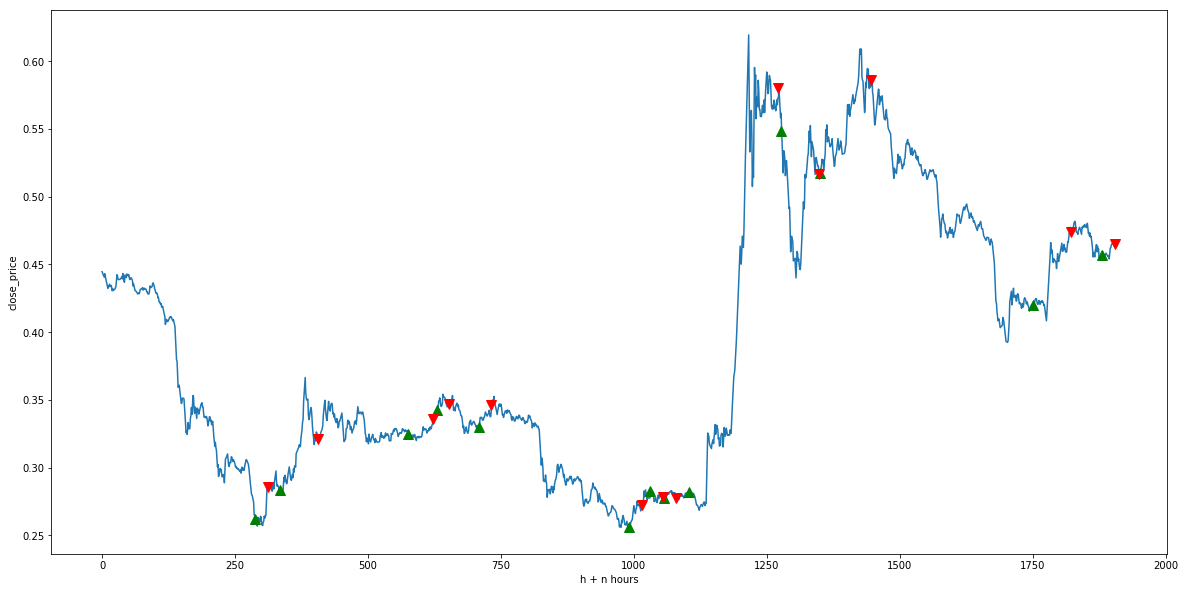

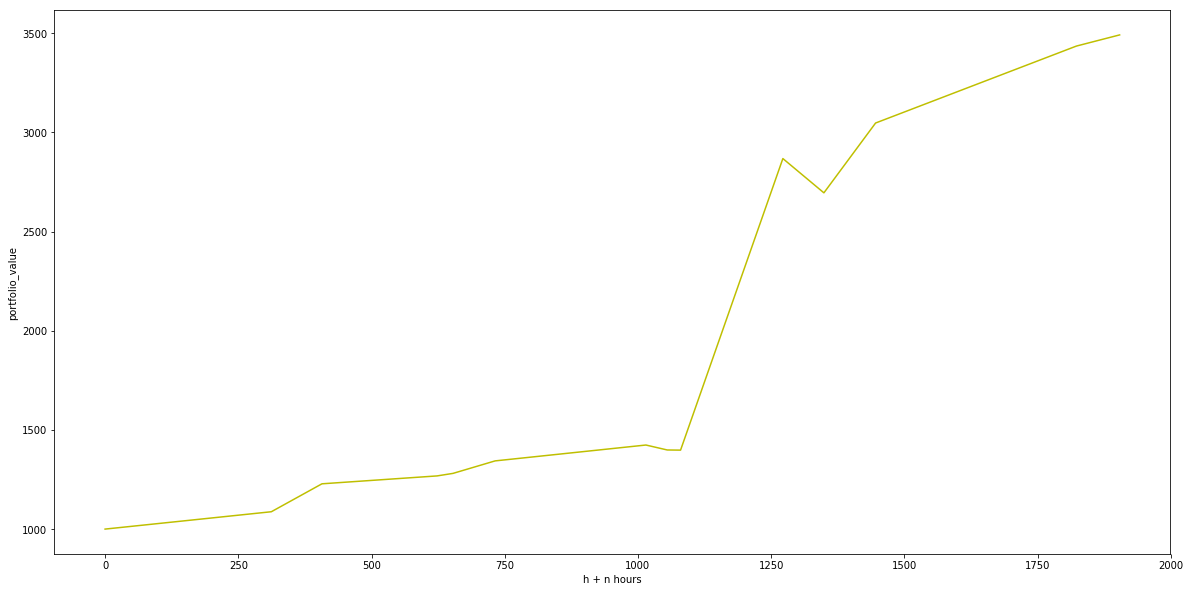

In [61]:
signals_x, signals_y, x_sell, y_sell, amount_x, amount_y = backtest.get_signals()

plt.figure(figsize=(20,10))
plt.plot(close_price)
plt.plot(signals_x, signals_y, '^', markersize=10, color='g')
plt.plot(x_sell, y_sell, 'v', markersize=10, color='r')
plt.xlabel('h + n hours')
plt.ylabel('close_price')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(amount_x, amount_y, color='y')
plt.xlabel('h + n hours')
plt.ylabel('portfolio_value')
plt.show()